# [ 📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using GLM, Effects, MultipleTesting
import AnovaGLM as aov

using MLJ: schema

In [2]:
include("pubh.jl");
set_default_plot_size(15cm, 12cm)
@rlibrary readr
@rimport pubh

In [3]:
#| output: false
R"""
library(pubh)
library(sjlabelled)
""";

┌ Warning: RCall.jl: Loading required package: emmeans
│ Loading required package: ggformula
│ Loading required package: ggplot2
│ Loading required package: scales
│ Loading required package: ggridges
│ 
│ New to ggformula?  Try the tutorials: 
│ 	learnr::run_tutorial("introduction", package = "ggformula")
│ 	learnr::run_tutorial("refining", package = "ggformula")
│ Loading required package: gtsummary
│ Loading required package: huxtable
│ 
│ Attaching package: ‘huxtable’
│ 
│ The following object is masked from ‘package:gtsummary’:
│ 
│     as_flextable
│ 
│ The following object is masked from ‘package:scales’:
│ 
│     number_format
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     theme_grey
│ 
│ Loading required package: magrittr
└ @ RCall ~/.julia/packages/RCall/dDAVd/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘sjlabelled’
│ 
│ The following object is masked from ‘package:huxtable’:
│ 
│     set_label
│ 
│ The following object is masked from ‘packa

# Count Data

In [4]:
quine = rcopy(R"MASS::quine")
quine |> schema

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ Eth   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ Sex   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ Age   │ Multiclass{4} │ CategoricalValue{String, UInt32} │
│ Lrn   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ Days  │ Count         │ Int64                            │
└───────┴───────────────┴──────────────────────────────────┘


We change the name of the factors for `Eth` to Aboriginal and White and the `Sex` ones to Male and Female.

In [5]:
levels(quine.Eth)

2-element Vector{String}:
 "A"
 "N"

In [6]:
quine.Eth = recode(
  quine.Eth,
  "A" => "Aboriginal" ,
  "N" => "White"
)

quine.Sex = recode(
  quine.Sex,
  "M" => "Male",
  "F" => "Female"
);

In [7]:
#| output: asis
R"""
quine = $quine |>
  var_labels(
    Days = "Number of absent days",
    Eth = "Ethnicity",
    Age = "Age group",
    Lrn = "Learner status"
)

quine |> 
  cross_tbl(by = "Eth") |> 
  theme_pubh(2) |>
  set_caption("Descriptve statistics by ethnicty.") |> 
  add_footnote("n (%); Median (IQR)", font_size = 9) |>
  print_html()
""";

<table class="huxtable" data-quarto-disable-processing="true" style="border-collapse: collapse; border: 0px; margin-bottom: 2em; margin-top: 2em; ; margin-left: auto; margin-right: auto;  ">
<caption style="caption-side: top; text-align: center;">Descriptve statistics by ethnicty.</caption><col><col><col><col><tr>
<th style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold;"></th><th colspan="2" style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold;"><p><strong>Ethnicity</strong></p>
</th><th style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold;"></th></tr>
<tr>
<th style="vertical-align: top

We start by an intercept only model:

In [8]:
model_0 = glm(@formula(Days ~ 1), quine, Poisson())
glm_coef(model_0 |> coeftable |> DataFrame)

1×5 DataFrame
 Row │ Name         Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String       Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────
   1 │ (Intercept)   16.459     15.814      17.13       0.0

## Univariate model

Model estimating the effect of ethnicity:

In [9]:
levels!(quine.Eth, ["White", "Aboriginal"]);

In [10]:
model_1 = glm(@formula(Days ~ Eth), quine, Poisson())
glm_coef(model_1 |> coeftable |> DataFrame)

2×5 DataFrame
 Row │ Name             Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String           Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────────
   1 │ (Intercept)       12.182     11.427     12.987       0.0
   2 │ Eth: Aboriginal    1.743      1.606      1.892       0.0

## Multivariate analysis

The potential confounders that we want to control for in this analysis are sex, age group and type of learner.

In [11]:
model_2 = glm(@formula(Days ~ Eth + Sex + Age + Lrn), quine, Poisson())
aov.anova(model_2, type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

Days ~ 1 + Eth + Sex + Age + Lrn

Table:
───────────────────────────────────────────────
             DOF  Deviance        χ²  Pr(>|χ²|)
───────────────────────────────────────────────
(Intercept)    1   2092.08  980.0371     <1e-99
Eth            1   1925.24  166.8448     <1e-37
Sex            1   1910.83   14.4053     0.0001
Age            3   1742.50  168.3256     <1e-35
Lrn            1   1696.71   45.7980     <1e-10
───────────────────────────────────────────────



In [12]:
glm_coef(model_2 |> coeftable |> DataFrame)

7×5 DataFrame
 Row │ Name             Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String           Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────────
   1 │ (Intercept)       10.416      9.254     11.725       0.0
   2 │ Eth: Aboriginal    1.705      1.571      1.851       0.0
   3 │ Sex: Female        0.851      0.783      0.925       0.0
   4 │ Age: F1            0.716      0.624      0.822       0.0
   5 │ Age: F2            1.294      1.145      1.463       0.0
   6 │ Age: F3            1.534      1.343      1.751       0.0
   7 │ Lrn: SL            1.418      1.28       1.57        0.0

## Goodness of fit

When we use the Poisson distribution, we assume that the mean is equal to the variance. In other words, the residual deviance should be equal to the residual degrees of freedom. You obtain the corresponding values as part of the summary of the model. When this is not the case, we have overdispersion in our model.

We can check for overdispersion:

In [13]:
deviance(model_2) / dof_residual(model_2) |> r3

12.119

## Negative Binomial models

When we have overdispersion, we have the alternative to scale the standard errors by using a Quasi-Poisson distribution or by using a Negative Binomial Distribution of the error.

In [14]:
model_nb = glm(
  @formula(Days ~ Eth + Sex + Age + Lrn), 
  quine, NegativeBinomial(2.0),
  LogLink()
);

In [15]:
aov.anova(model_nb, type=3)

Analysis of Variance

Type 3 test / F test

Days ~ 1 + Eth + Sex + Age + Lrn

Table:
──────────────────────────────────────────────────────────
             DOF  ΔDeviance  Mean ΔDev   F value  Pr(>|F|)
──────────────────────────────────────────────────────────
(Intercept)    1   257.72     257.72    173.7053    <1e-25
Eth            1    19.56      19.56     13.1808    0.0004
Sex            1     0.4216     0.4216    0.2842    0.5948
Age            3    17.97       5.9910    4.0379    0.0087
Lrn            1     3.8783     3.8783    2.6139    0.1082
(Residuals)  139   206.23       1.4837              
──────────────────────────────────────────────────────────



In [16]:
#| code-fold: true
model2_nb = glm(
  @formula(Days ~ Eth + Age), 
  quine, NegativeBinomial(2.0),
  LogLink()
)

aov.anova(model2_nb, type=3)

Analysis of Variance

Type 3 test / F test

Days ~ 1 + Eth + Age

Table:
──────────────────────────────────────────────────────────
             DOF  ΔDeviance  Mean ΔDev   F value  Pr(>|F|)
──────────────────────────────────────────────────────────
(Intercept)    1     394.12   394.12    250.9260    <1e-32
Eth            1      19.01    19.01     12.1032    0.0007
Age            3      17.03     5.6759    3.6137    0.0149
(Residuals)  141     221.47     1.5707              
──────────────────────────────────────────────────────────



We can test if the two models are significantly different, if they are not (p > 0.05) it means we should keep the model with a smaller number of parameters, as they are not making the model significantly better:

In [17]:
aov.anova(model_nb, model2_nb)

┌ Warning: Could not check whether models are nested: results may not be meaningful
└ @ AnovaGLM ~/.julia/packages/AnovaGLM/CO3t7/src/anova.jl:162


Analysis of Variance

Type 1 test / F test

Model 1: Days ~ 1 + Eth + Age
Model 2: Days ~ 1 + Eth + Sex + Age + Lrn

Table:
─────────────────────────────────────────────────────────────
   DOF  ΔDOF  Res.DOF  Deviance  ΔDeviance  F value  Pr(>|F|)
─────────────────────────────────────────────────────────────
1    6            141    243.24                        
2    8     2      139    239.11     4.1240   1.3898    0.2526
─────────────────────────────────────────────────────────────



The models are not statistically different and therefore, the model that has only 2 parameters is a better model. In other words, having sex and type of learner in the model, does not improve significantly the model.

### Table of coefficients

In [18]:
glm_coef(model2_nb |> coeftable |> DataFrame)

5×5 DataFrame
 Row │ Name             Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String           Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────────
   1 │ (Intercept)       11.874      8.062     17.488     0.0
   2 │ Eth: Aboriginal    1.747      1.285      2.375     0.0
   3 │ Age: F1            0.685      0.435      1.077     0.101
   4 │ Age: F2            1.212      0.766      1.916     0.412
   5 │ Age: F3            1.293      0.802      2.082     0.292

### Effect plot

In [19]:
eff_nb = effects(
  Dict(
    :Eth => levels(quine.Eth),
    :Age => levels(quine.Age)
  ),
  model2_nb, invlink=exp
)

eff_nb |> head

5×6 DataFrame
 Row │ Eth         Age     Days      err      lower     upper    
     │ String      String  Float64   Float64  Float64   Float64  
─────┼───────────────────────────────────────────────────────────
   1 │ White       F0      11.8742   2.34554   9.52861  14.2197
   2 │ Aboriginal  F0      20.7447   4.10459  16.6401   24.8493
   3 │ White       F1       8.12973  1.29996   6.82976   9.42969
   4 │ Aboriginal  F1      14.203    2.36403  11.839    16.5671
   5 │ White       F2      14.3877   2.41754  11.9702   16.8053

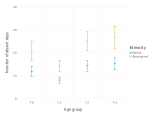

In [20]:
#| label: fig-fig1
plot(
  eff_nb,
  x=:Age, y=:Days, color=:Eth,
  ymin=:lower, ymax=:upper,
  Geom.point, Geom.errorbar,
  Guide.xlabel("Age group"),
  Guide.ylabel("Number of absent days"),
  Guide.colorkey("Ethnicity")
)

# Incidence Rates

In [21]:
seizures = read_rds("data/seizures.rds") |> rcopy
seizures |> schema

┌────────┬───────────────┬──────────────────────────────────┐
│ names  │ scitypes      │ types                            │
├────────┼───────────────┼──────────────────────────────────┤
│ id     │ Continuous    │ Float64                          │
│ treat  │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ nseize │ Continuous    │ Float64                          │
│ pweeks │ Continuous    │ Float64                          │
└────────┴───────────────┴──────────────────────────────────┘


In [22]:
model_sei = glm(
  @formula(nseize ~ treat),
  seizures, offset=log.(seizures.pweeks),
  Poisson(),
  LogLink()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

nseize ~ 1 + treat

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     z  Pr(>|z|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.674798   0.0962249  7.01    <1e-11   0.486201    0.863395
treat: New   0.21024    0.131131   1.60    0.1089  -0.0467727   0.467253
────────────────────────────────────────────────────────────────────────

In [23]:
glm_coef(model_sei |> coeftable |> DataFrame)

2×5 DataFrame
 Row │ Name         Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String       Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────
   1 │ (Intercept)    1.964      1.626      2.371     0.0
   2 │ treat: New     1.234      0.954      1.596     0.109

In [24]:
deviance(model_sei) / dof_residual(model_sei) |> r3

5.935

In [25]:
model_snb = glm(
  @formula(nseize ~ treat),
  seizures, offset=log.(seizures.pweeks),
  NegativeBinomial(),
  LogLink()
);

In [26]:
glm_coef(model_snb |> coeftable |> DataFrame)

2×5 DataFrame
 Row │ Name         Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String       Float64  Float64    Float64    Float64  
─────┼──────────────────────────────────────────────────────
   1 │ (Intercept)    2.17       1.268      3.714     0.005
   2 │ treat: New     1.384      0.651      2.944     0.399